In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wav
import sounddevice as sd
import torchaudio
from scipy.fftpack import fft, ifft

In [17]:
file_path = "audio_16.wav"
fs, audio = wav.read(file_path)
print(f"Sample Rate: {fs} Hz")
print(f"Data Type: {audio.dtype}")

Sample Rate: 16000 Hz
Data Type: int16


In [18]:
from IPython.display import Audio
Audio(audio, rate=fs)

In [19]:
# Load and plot the time-domain signal
def plot_time_signal(audio, fs):
    time = np.linspace(0, len(audio) / fs, num=len(audio))
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Time-Domain Signal")
    plt.show()

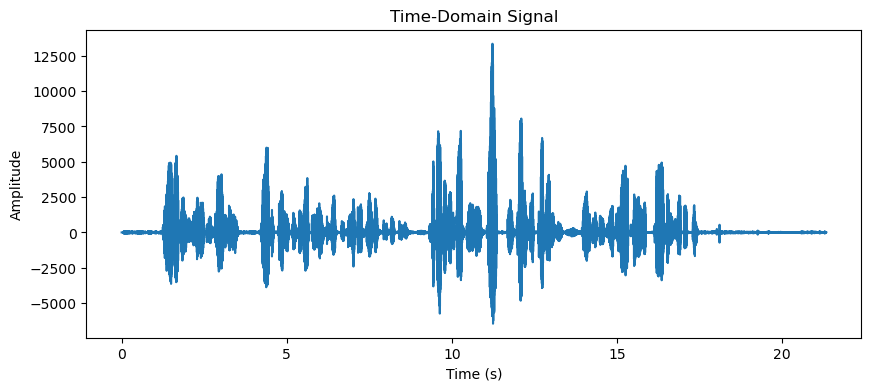

In [20]:
plot_time_signal(audio, fs)

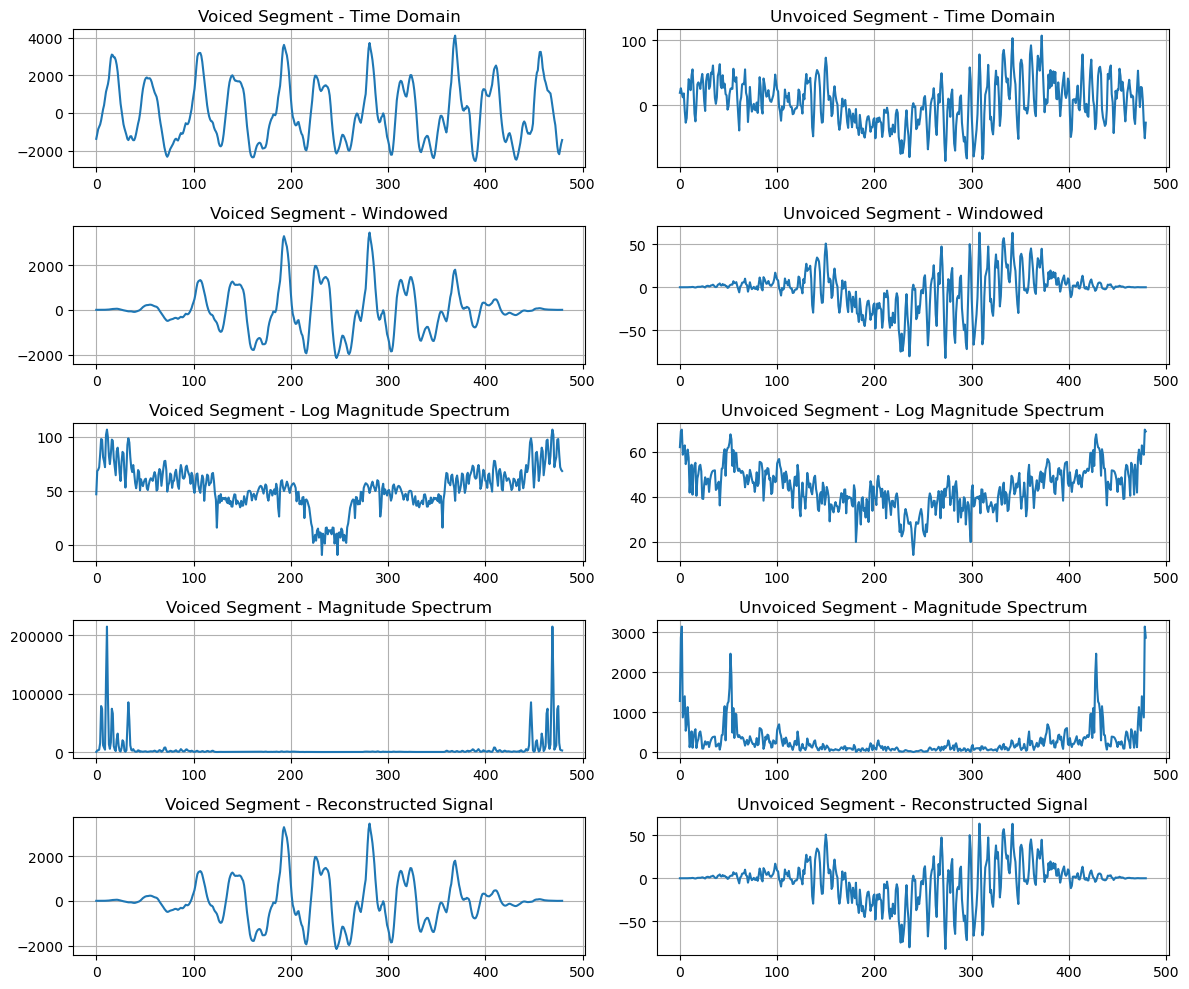

In [21]:
voiced_segment = audio[int(3.0 * fs): int(3.03 * fs)]  # Voiced - AAJ
unvoiced_segment = audio[int(9.0 * fs): int(9.03 * fs)]  # Unvoiced - Shakal

# Apply Hanning window
window = np.hanning(len(voiced_segment))
voiced_windowed = voiced_segment * window
unvoiced_windowed = unvoiced_segment * window

# Compute DFT
voiced_dft = fft(voiced_windowed)
unvoiced_dft = fft(unvoiced_windowed)

# Compute Log Magnitude Spectrum
voiced_log_magnitude = 20 * np.log10(np.abs(voiced_dft) + 1e-10)
unvoiced_log_magnitude = 20 * np.log10(np.abs(unvoiced_dft) + 1e-10)

# Compute IDFT
voiced_reconstructed = np.real(ifft(voiced_dft))
unvoiced_reconstructed = np.real(ifft(unvoiced_dft))

# Plot for Voiced Segment
plt.figure(figsize=(12, 10))

plt.subplot(5, 2, 1)
plt.plot(voiced_segment)
plt.title("Voiced Segment - Time Domain")
plt.grid()

plt.subplot(5, 2, 3)
plt.plot(voiced_windowed)
plt.title("Voiced Segment - Windowed")
plt.grid()

plt.subplot(5, 2, 5)
plt.plot(voiced_log_magnitude)
plt.title("Voiced Segment - Log Magnitude Spectrum")
plt.grid()

plt.subplot(5, 2, 7)
plt.plot(np.abs(voiced_dft))
plt.title("Voiced Segment - Magnitude Spectrum")
plt.grid()

plt.subplot(5, 2, 9)
plt.plot(voiced_reconstructed)
plt.title("Voiced Segment - Reconstructed Signal")
plt.grid()

# Plot for Unvoiced Segment
plt.subplot(5, 2, 2)
plt.plot(unvoiced_segment)
plt.title("Unvoiced Segment - Time Domain")
plt.grid()

plt.subplot(5, 2, 4)
plt.plot(unvoiced_windowed)
plt.title("Unvoiced Segment - Windowed")
plt.grid()

plt.subplot(5, 2, 6)
plt.plot(unvoiced_log_magnitude)
plt.title("Unvoiced Segment - Log Magnitude Spectrum")
plt.grid()

plt.subplot(5, 2, 8)
plt.plot(np.abs(unvoiced_dft))
plt.title("Unvoiced Segment - Magnitude Spectrum")
plt.grid()

plt.subplot(5, 2, 10)
plt.plot(unvoiced_reconstructed)
plt.title("Unvoiced Segment - Reconstructed Signal")
plt.grid()

plt.tight_layout()
plt.show()


- Signal is reconstructed but not perfectly because there is a windowing involved.
    - Partial reconstruction in voiced segments
    - Degradation in unvoiced segments

This is spectral leakage.

# Low time liftering

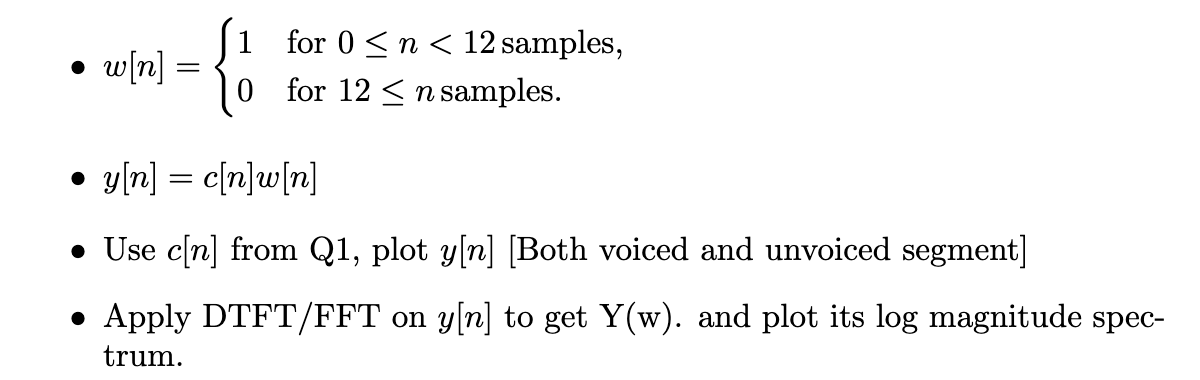

/var/folders/2d/mf93wtk914vbrkclc8d3hrt40000gn/T/ipykernel_52182/1462168835.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


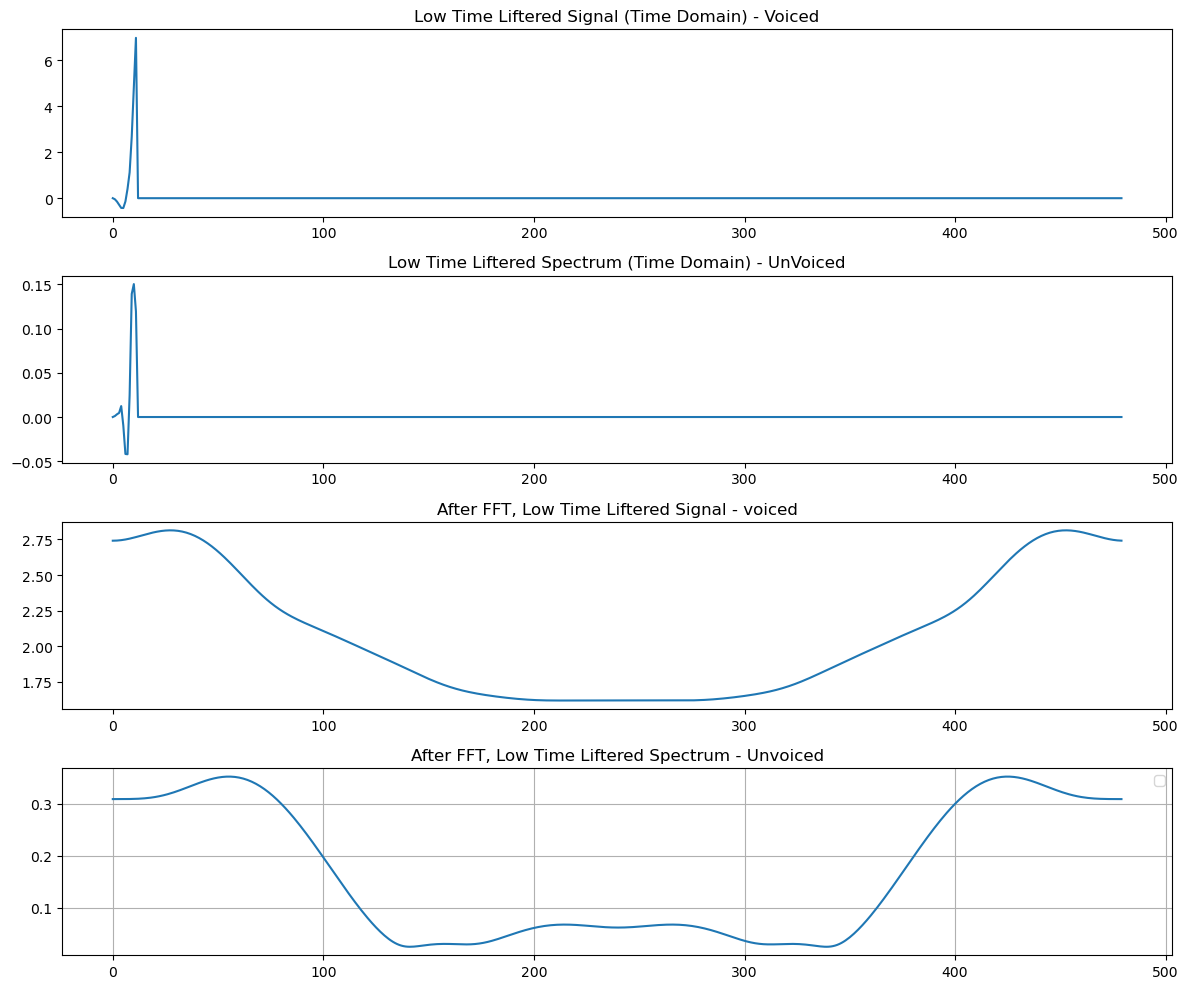

In [22]:
plt.figure(figsize=(12, 10))

voiced_segment = voiced_reconstructed
unvoiced_segment = unvoiced_reconstructed

# Define low-time liftering window (first 12 samples kept)
w_low = np.concatenate([np.ones(12), np.zeros(len(voiced_segment) - 12)])
y_n_voiced = voiced_segment * w_low

plt.subplot(4, 1, 1)
plt.plot(y_n_voiced)
plt.title("Low Time Liftered Signal (Time Domain) - Voiced")

w_low = np.concatenate([np.ones(12), np.zeros(len(unvoiced_segment) - 12)])
y_n_unvoiced = unvoiced_segment * w_low

plt.subplot(4, 1, 2)
plt.plot(y_n_unvoiced)
plt.title("Low Time Liftered Spectrum (Time Domain) - UnVoiced")




# Compute FFT
Y_low_voiced = np.abs(np.fft.fft(y_n_voiced))

# Compute FFT
Y_low_unvoiced = np.abs(np.fft.fft(y_n_unvoiced))

# Convert to log scale
Y_low_log_voiced = np.log1p(Y_low_voiced)

# Convert to log scale
Y_low_log_unvoiced = np.log1p(Y_low_unvoiced)

plt.subplot(4, 1, 3)
plt.plot(Y_low_log_voiced)
plt.title("After FFT, Low Time Liftered Signal - voiced")

plt.subplot(4, 1, 4)
plt.plot(Y_low_log_unvoiced)
plt.title("After FFT, Low Time Liftered Spectrum - Unvoiced")

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


- w[n] is a binary function that allows only the first 12 samples of the signal to pass through. 
- Low-time liftering preserves the slowly varying components (formants in speech).
- It effectively removes high-frequency components like noise and rapid changes.
- This it extracts vocal characteristics of the speaker.

# High time Liftering

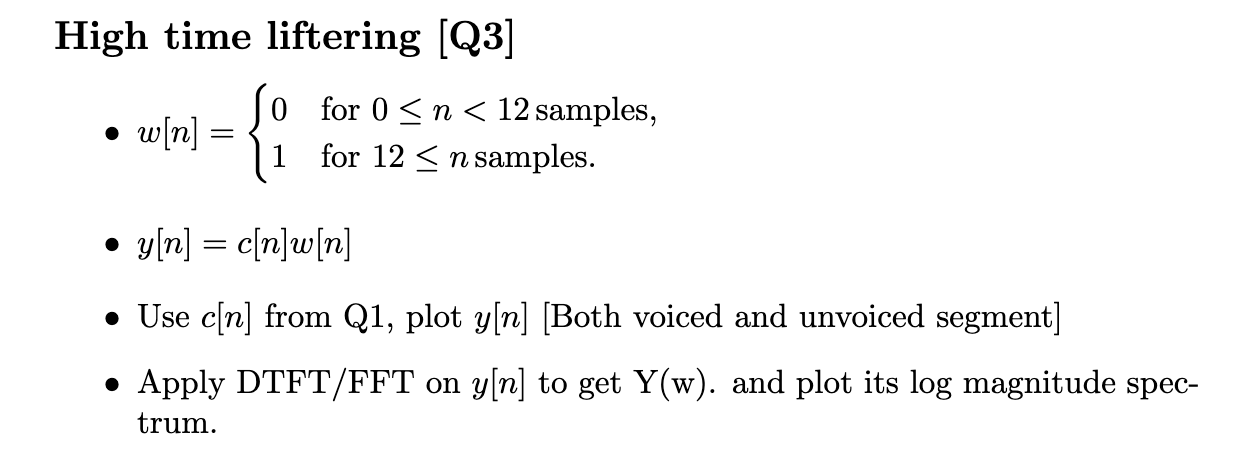

/var/folders/2d/mf93wtk914vbrkclc8d3hrt40000gn/T/ipykernel_52182/539095308.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


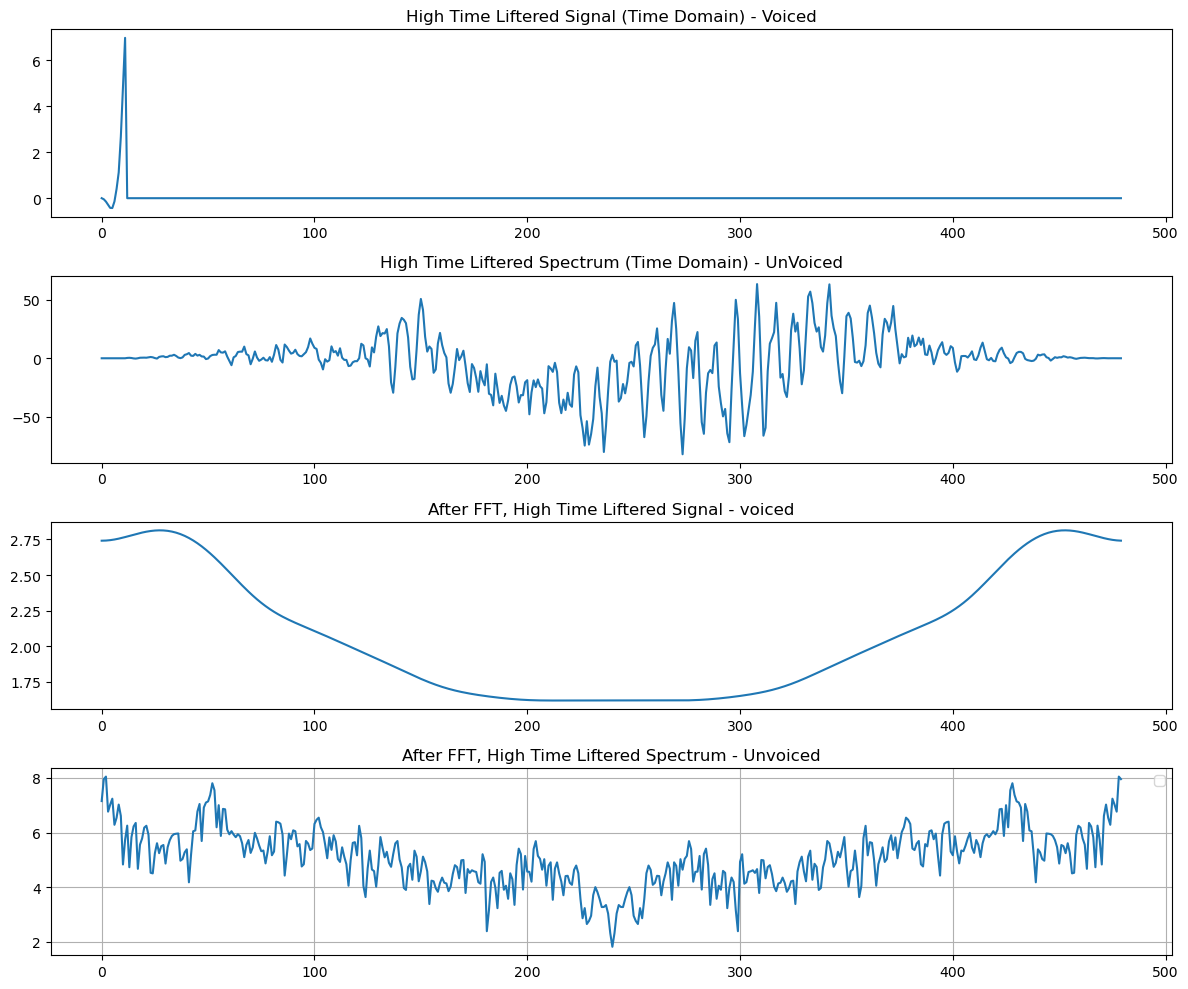

In [23]:
plt.figure(figsize=(12, 10))

voiced_segment = voiced_reconstructed
unvoiced_segment = unvoiced_reconstructed

# Define low-time liftering window (first 12 samples kept)
w_low = np.concatenate([np.ones(12), np.zeros(len(voiced_segment) - 12)])
y_n_voiced = voiced_segment * w_low

plt.subplot(4, 1, 1)
plt.plot(y_n_voiced)
plt.title("High Time Liftered Signal (Time Domain) - Voiced")

w_low = np.concatenate([np.zeros(12), np.ones(len(unvoiced_segment) - 12)])
y_n_unvoiced = unvoiced_segment * w_low

plt.subplot(4, 1, 2)
plt.plot(y_n_unvoiced)
plt.title("High Time Liftered Spectrum (Time Domain) - UnVoiced")


# Compute FFT
Y_low_voiced = np.abs(np.fft.fft(y_n_voiced))

# Compute FFT
Y_low_unvoiced = np.abs(np.fft.fft(y_n_unvoiced))

# Convert to log scale
Y_low_log_voiced = np.log1p(Y_low_voiced)

# Convert to log scale
Y_low_log_unvoiced = np.log1p(Y_low_unvoiced)

plt.subplot(4, 1, 3)
plt.plot(Y_low_log_voiced)
plt.title("After FFT, High Time Liftered Signal - voiced")

plt.subplot(4, 1, 4)
plt.plot(Y_low_log_unvoiced)
plt.title("After FFT, High Time Liftered Spectrum - Unvoiced")

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


High Time Filtering
- Voiced: Keeps information like pitch
- Unvoiced : Keeps the burst information, but looses the actual information

Low Time Filtering
- Voiced: Smoothening of frequency content
- Unvoiced : Same as abiove
